# Title : Object detection using Transfer Learning of CNN architectures
Aim: Object detection using Transfer Learning of CNN architectures
    
a. Load in a pre-trained CNN model trained on a large dataset

b. Freeze parameters (weights) in model’s lower convolutional layers

c. Add custom classifier with several layers of trainable parameters to model

d. Train classifier layers on training data available for task

e. Fine-tune hyper parameters and unfreeze more layers as needed

dataset
https://drive.google.com/file/d/1lKQYLe3WrhUtV0V0PLsp47dJhA-tWACj/view?usp=drive_link

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten  #Dense layer is a fully connected layer (feedforward layer) #Flatten layer is used to convert multi-dimensional data, such as images, into a one-dimensional vector
from tensorflow.keras.optimizers import Adam  # Adam optimizer is a popular optimization algorithm used in training deep learning models,
from tensorflow.keras.preprocessing.image import ImageDataGenerator #used for image data augmentation rotation, resizing, shearing, flipping, zooming
import numpy as np

#### Pre processing img data 

In [2]:
train_dir = "Datasets/cifar-10-img/train"
test_dir = "Datasets/cifar-10-img/test"

train_datagen = ImageDataGenerator(  #Keras utility for data augmentation
    rescale=1.0 / 255,  #scales the pixel values of the images in your dataset to be in the range [0, 1].
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# here batch_size is the number of images in each batch
train_batch_size = 5000
train_generator = train_datagen.flow_from_directory( #ImageDataGenerator that generates batches of augmented data from images stored in a directory
    train_dir,
    target_size=(32, 32),#images will be resized to a 32x32 pixel size
    batch_size=train_batch_size,
    class_mode='categorical' # specified 'categorical', which is appropriate for multi-class classification tasks
)


test_batch_size = 1000
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=test_batch_size,
    class_mode='categorical'
)

Found 40079 images belonging to 10 classes.
Found 9921 images belonging to 10 classes.


#### Selecting only first batch with 5000 images as train and test data

In [3]:
x_train, y_train =  train_generator[0]
x_test, y_test = test_generator[0]

print(len(x_train))
print(len(x_test))

5000
1000


#### a. Load in a pre-trained CNN model trained on a large dataset

In [4]:
# Load VGG16 without top layers  , VGG16 consists of 16 layers, which include 13 convolutional layers and 3 fully connected layers
weights_path = "imagenet"  #variable contains the path to a file that holds the pre-trained weights for the VGG16 model
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(32, 32, 3)) #variable will store the VGG16 model with the specified configuration

#### b. Freeze parameters (weights) in model’s lower convolutional layers

In [6]:
for layer in base_model.layers:
   layer.trainable = False  #Setting the layers to non-trainable means that the weights and parameters of these layers will not be updated during the training of your specific task

#### c. Add custom classifier with several layers of trainable parameters to model

In [7]:
x = Flatten()(base_model.output)  #This line adds a Flatten layer on top of the output of the base_model
x = Dense(256, activation='relu')(x) #This line adds a fully connected layer with 256 neurons and ReLU
x = tf.keras.layers.Dropout(0.3)(x) #It creates a dropout layer with a dropout rate of 0.3.
x = Dense(256, activation='relu')(x) #This creates a dense layer with 256 neurons and applies ReLU 
x = tf.keras.layers.Dropout(0.3)(x)#It creates a dropout layer with a dropout rate of 0.3.
predictions = Dense(10, activation='softmax')(x)  #fully connected layer with 10 neurons (assuming this is for a classification task with 10 classes) and a softmax activation function is added. This layer produces the output of the model, which represents the predicted class probabilities for the input data.

# Create the model
model = Model(inputs=base_model.input, outputs=predictions) #This creates a new Keras model where base_model.input specifies the input of the model (the input of the VGG16 base model), and predictions represents the output of the model
# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']) #You are specifying the Adam optimizer for training,s specifies the evaluation metric

#### d. Train classifier layers on training data available for task

In [8]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))  #each training epoch, the model's performance will be evaluated

Epoch 1/10
79/79 [==============================] - 28s 334ms/step - loss: 1.9523 - accuracy: 0.2888 - val_loss: 1.5625 - val_accuracy: 0.4390
Epoch 2/10
79/79 [==============================] - 27s 342ms/step - loss: 1.5994 - accuracy: 0.4292 - val_loss: 1.4154 - val_accuracy: 0.4870
Epoch 3/10
79/79 [==============================] - 28s 355ms/step - loss: 1.4485 - accuracy: 0.4902 - val_loss: 1.3756 - val_accuracy: 0.4960
Epoch 4/10
79/79 [==============================] - 28s 349ms/step - loss: 1.3747 - accuracy: 0.5142 - val_loss: 1.3308 - val_accuracy: 0.5080
Epoch 5/10
79/79 [==============================] - 27s 349ms/step - loss: 1.2975 - accuracy: 0.5412 - val_loss: 1.3251 - val_accuracy: 0.5270
Epoch 6/10
79/79 [==============================] - 27s 348ms/step - loss: 1.2485 - accuracy: 0.5584 - val_loss: 1.3045 - val_accuracy: 0.5320
Epoch 7/10
79/79 [==============================] - 28s 353ms/step - loss: 1.1807 - accuracy: 0.5704 - val_loss: 1.2889 - val_accuracy: 0.5420

#### e. Fine-tune hyper parameters and unfreeze more layers as needed

In [9]:
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(32, 32, 3))
# freeze all layers first
for layer in base_model.layers:
   layer.trainable = False

# unfreeze last 4 layers of base model
for layer in base_model.layers[len(base_model.layers) - 4:]:
   layer.trainable = True

# fine-tuning hyper parameters
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# training fine tuned model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
79/79 [==============================] - 94s 1s/step - loss: 1.8541 - accuracy: 0.3178 - val_loss: 1.6245 - val_accuracy: 0.4170
Epoch 2/10
79/79 [==============================] - 93s 1s/step - loss: 1.3206 - accuracy: 0.5326 - val_loss: 1.4945 - val_accuracy: 0.5330
Epoch 3/10
79/79 [==============================] - 97s 1s/step - loss: 1.0634 - accuracy: 0.6348 - val_loss: 1.2190 - val_accuracy: 0.5830
Epoch 4/10
79/79 [==============================] - 98s 1s/step - loss: 0.9265 - accuracy: 0.6892 - val_loss: 1.0803 - val_accuracy: 0.6190
Epoch 5/10
79/79 [==============================] - 96s 1s/step - loss: 0.7634 - accuracy: 0.7442 - val_loss: 1.1436 - val_accuracy: 0.6280
Epoch 6/10
79/79 [==============================] - 102s 1s/step - loss: 0.6933 - accuracy: 0.7688 - val_loss: 1.1338 - val_accuracy: 0.6380
Epoch 7/10
79/79 [==============================] - 99s 1s/step - loss: 0.5512 - accuracy: 0.8156 - val_loss: 1.4275 - val_accuracy: 0.6030
Epoch 8/10
79/79 [=

In [10]:
import matplotlib.pyplot as plt
predicted_value = model.predict(x_test)  # This line uses your trained model to make predictions on the testing data (x_test

32/32 [==============================] - 5s 137ms/step


In [11]:
labels = list(test_generator.class_indices.keys())  #This code extracts the class names (labels) by obtaining the keys from the dictionary, and then it converts those keys into a list. This list will contain the class labels you can use for further analysis

Preditcted:  deer
Actual:  deer


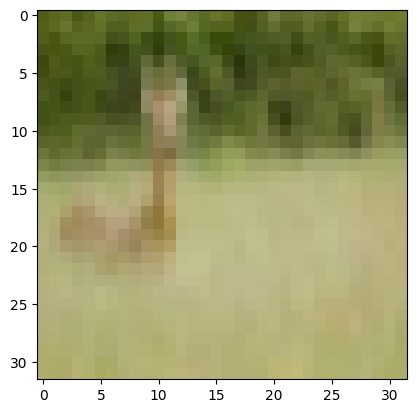

In [12]:
n = 900#You're selecting a specific index (n) from your testing data
plt.imshow(x_test[n]) # line uses Matplotlib to display the image at index n
print("Preditcted: ",labels[np.argmax(predicted_value[n])])
print("Actual: ", labels[np.argmax(y_test[n])])  #is used to find the index with the highest predicted value, which corresponds to the predicted class